# Libraries

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import model as mainmodel
from src.models import modelConv2d
from src.models import modelineal
from src.models import decoders
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision
import wandb
import random
import os


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

## Numerical Model

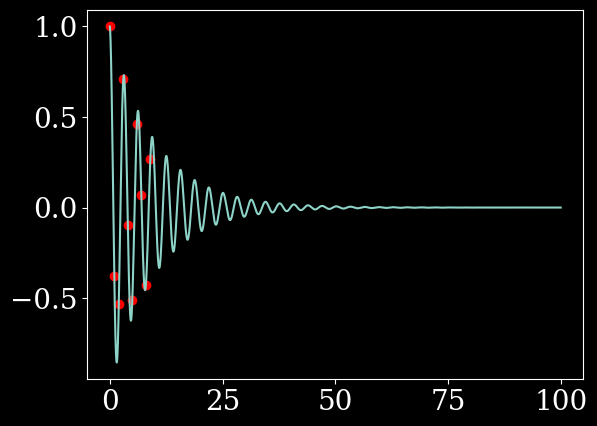

0.05


In [36]:
t = np.arange(0,100, 1/100)

y = np.exp(-0.1*t)*np.cos(2*t)
#np.exp(-0.1*t)*
t_s = np.arange(0,10, 1)

y_s = np.exp(-0.1*t_s)*np.cos(2*t_s)

plt.plot(t, y)
plt.scatter(t_s, y_s,c='r')

plt.show()

print(t[5]-t[0])

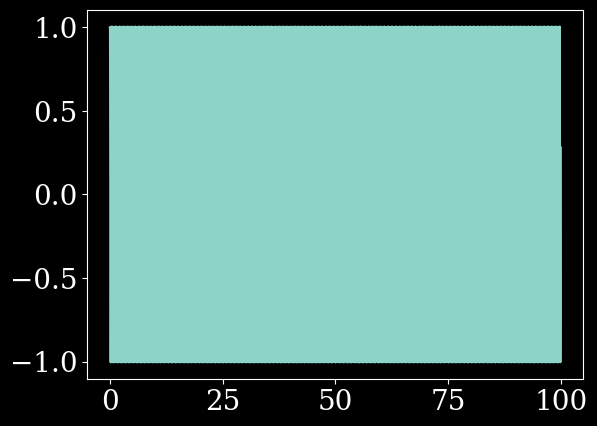

In [33]:
y_list =[]

y0 = y[0]
y1 = y[1]

y_list.append(y0)
y_list.append(y1)

dt = 0.1*1

for i in range(2, len(t)):
    
    y2 = y1 +(y1 - y0) - dt*(0.0*(y1-y0) +dt*4*y1)

    y_list.append(y2)
    y0 = y1
    y1 = y2
    

y_list = np.array(y_list)

plt.plot(t, y_list)
plt.show()

# Pendulum

### Load Data

In [10]:
t,a = genData.generateDynamics(1,(-1))
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Motion")

<Figure size 640x480 with 0 Axes>

### Visualizations

In [70]:
genData.generateVideo(a,DynamicsType = "Motion", name = "Pendulum_Original_video")

Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


C:\Users\aleja\AppData\Local\Temp\ipykernel_18784\296776735.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
C:\Users\aleja\AppData\Local\Temp\ipykernel_18784\296776735.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


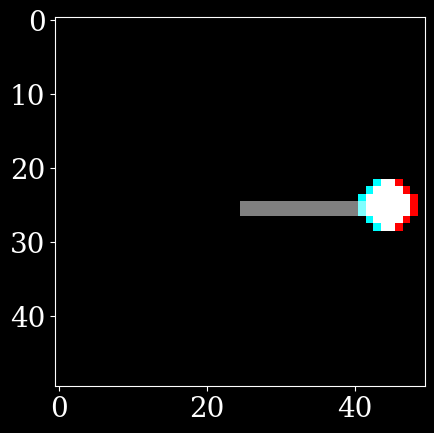

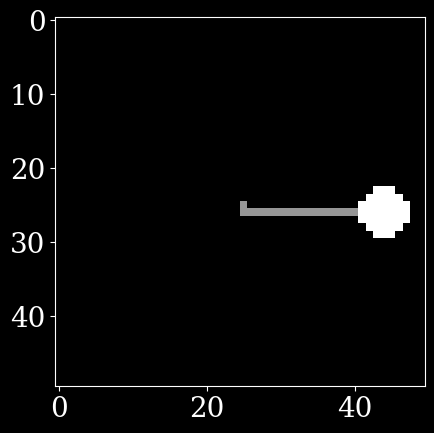

In [71]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type="Motion")

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')


### Model 

In [11]:

#train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)
modelAE = models.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

IndexError: list index out of range

In [13]:
visual_loader= loader.getLoader(a, type="Motion", split=False)
vu.visualize(modelAE, visual_loader, video_name = 'Conv2d_ExpVsPred.mp4')
vu.CompareLatent(modelAE, visual_loader)

NameError: name 'modelAE' is not defined

### Test Decoder

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Motion")
linearDecoder = decoders.convDecoder(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/Motion_Decoder', loss_name='decoder_loss')

Using device: cpu


wandb: ERROR Control-C detected -- Run data was not synced


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [5]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Motion")
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/Motion_Decoder_ExpVsPred.mp4')

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Video saved as ./Results/Motion_Decoder_ExpVsPred.mp4


### Test Encoder Phys

In [11]:
t,a = genData.generateDynamics(max=0.5, min = -0.5)
sr = 20
dt_sim = 1/100
dt = dt_sim*sr
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Motion", split = True,  dt=dt_sim, nInFrames = 5,sr = sr ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(dt = dt, initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/Motion_Decoder', loss_name='latent_loss')

Using device: cpu


alpha,▁
beta,▁
train_loss,▁
validation_loss,▁
alpha,1.0
beta,1.0
train_loss,18.97911
validation_loss,21.0499


Initial Loss 	 training loss: 18.412389160650463 	 validation loss: 19.259598350524904


TypeError: isnan(): argument 'input' (position 1) must be Tensor, not float

<Figure size 640x480 with 0 Axes>

In [44]:
sr = 20
visual_loader= loader.getLoader(a,type="Motion", split = False,   dt=1/100, nInFrames = 5,sr = sr ,  noise=False, shapeType='simple')
#vu.CompareLatent_end_phys(latentEncoder, visual_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


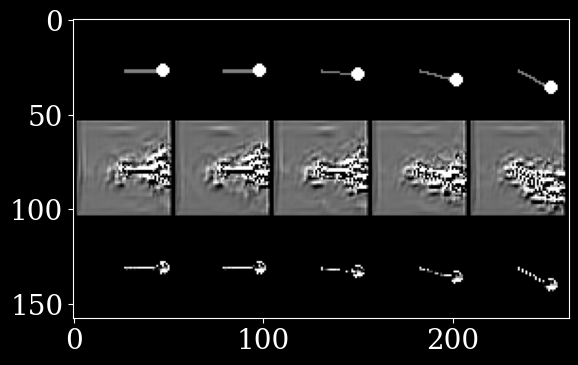

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


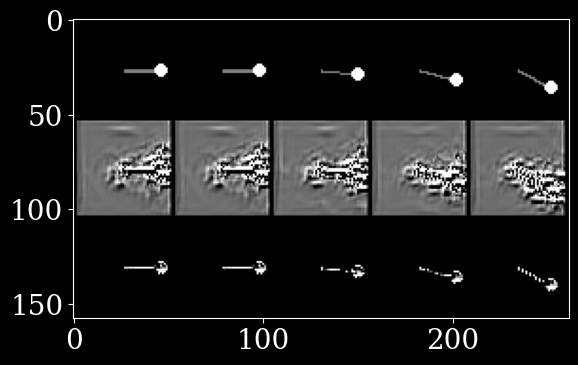

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


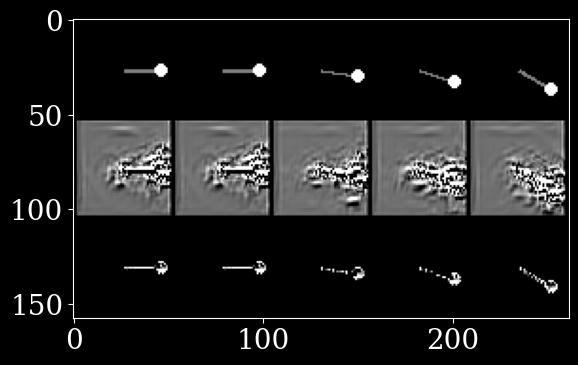

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


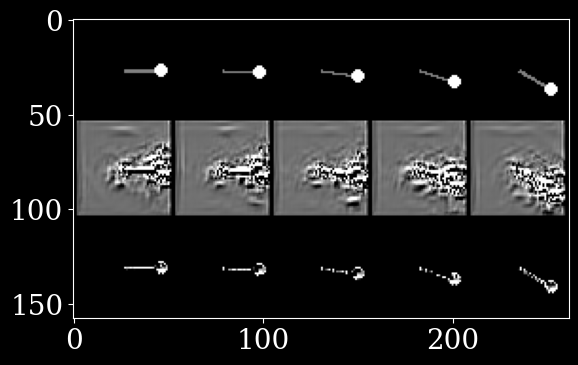

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


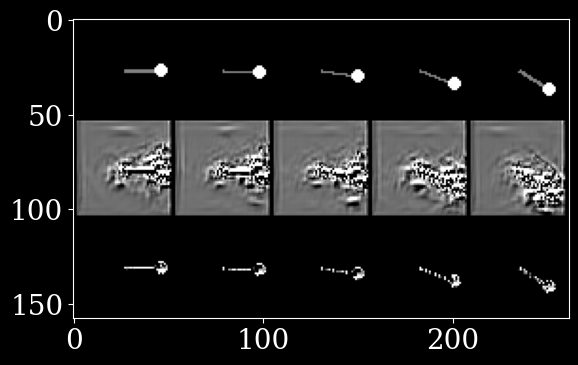

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


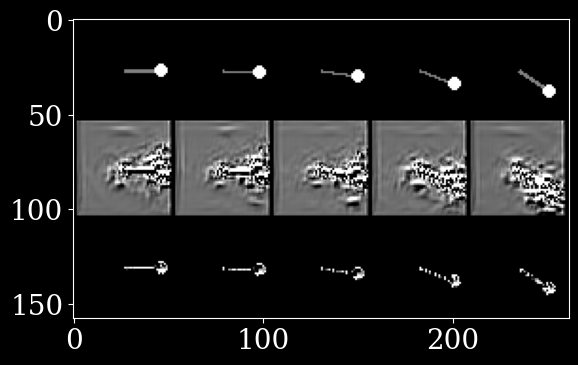

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


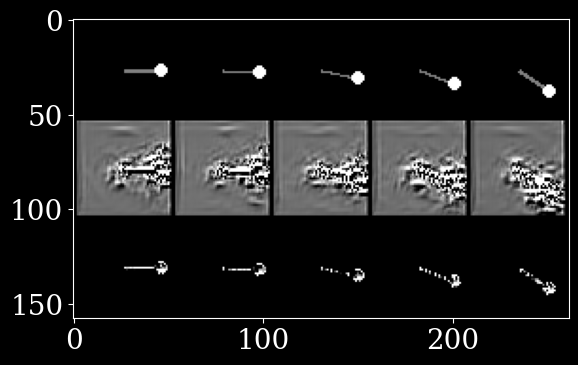

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


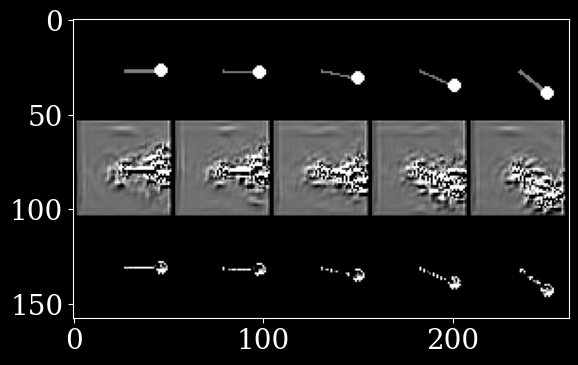

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


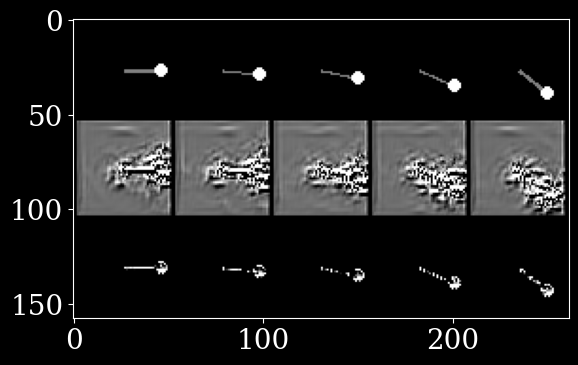

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


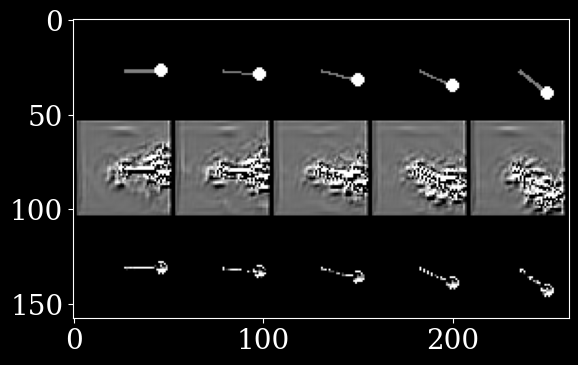

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


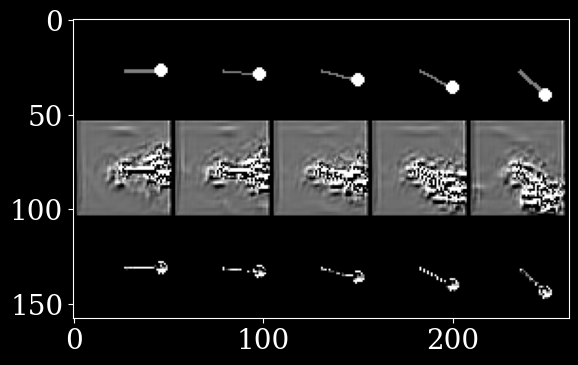

In [46]:
vu.view_masks(latentEncoder, visual_loader, iters = 10)

# double pendulum

In [5]:
#Get theta1 acceleration 
def theta1_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g):
    mass1 = -g*(2*m1 + m2)*np.sin(theta1)
    mass2 = -m2*g*np.sin(theta1 - 2*theta2)
    interaction = -2*np.sin(theta1 - theta2)*m2*np.cos(theta2_velocity**2*l2 + theta1_velocity**2*l1*np.cos(theta1 - theta2))
    normalization = l1*(2*m1 + m2 - m2*np.cos(2*theta1 - 2*theta2))
    
    theta1_ddot = (mass1 + mass2 + interaction)/normalization
    
    return theta1_ddot

#Get theta2 acceleration
def theta2_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g):
    system = 2*np.sin(theta1 - theta2)*(theta1_velocity**2*l1*(m1 + m2) + g*(m1 + m2)*np.cos(theta1) + theta2_velocity**2*l2*m2*np.cos(theta1 - theta2))
    normalization = l1*(2*m1 + m2 - m2*np.cos(2*theta1 - 2*theta2))
    
    theta2_ddot = system/normalization
    return theta2_ddot

#Update theta1
def theta1_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step):
    #Numerical Integration
    theta1_velocity += time_step*theta1_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g)
    theta1 += time_step*theta1_velocity
    return theta1, theta1_velocity

#Update theta2
def theta2_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step):
    #Numerical Integration
    theta2_velocity += time_step*theta2_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g)
    theta2 += time_step*theta2_velocity
    return theta2, theta2_velocity

#Run full double pendulum
def double_pendulum(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step,time_span):
    theta1_list = [theta1]
    theta2_list = [theta2]
    
    for t in time_span:
        theta1, theta1_velocity = theta1_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)
        theta2, theta2_velocity = theta2_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)

        theta1_list.append(theta1)
        theta2_list.append(theta2)
    
    x1 = l1*np.sin(theta1_list) #Pendulum 1 x
    y1 = -l1*np.cos(theta1_list) #Pendulum 1 y

    x2 = l1*np.sin(theta1_list) + l2*np.sin(theta2_list) #Pendulum 2 x
    y2 = -l1*np.cos(theta1_list) - l2*np.cos(theta2_list) #Pendulum 2 y
    
    return x1,y1,x2,y2

In [7]:
#Define system parameters
g = 9.8 #m/s^2

m1 = 1 #kg
m2 = 1 #kg

l1 = 1 #m
l2 = 1 #m

theta1 = np.radians(90)
theta2 = np.radians(45)

theta1_velocity = 0 #m/s
theta2_velocity = 0 #m/s

theta1_list = [theta1]
theta2_list = [theta2]

time_step = 20/300

time_span = np.linspace(0,20,300)
x1,y1,x2,y2 = double_pendulum(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step,time_span)

In [9]:
import imageio

#Make Gif
!mkdir frames
    
counter=0
images = []
for i in range(0,len(x1)):
    plt.figure(figsize = (6,6))

    plt.figure(figsize = (6,6))
    plt.plot([0,x1[i]],[0,y1[i]], "o-", color = "b", markersize = 7, linewidth=.7 )
    plt.plot([x1[i],x2[i]],[y1[i],y2[i]], "o-", color = "b", markersize = 7, linewidth=.7 )
    plt.title("Double Pendulum")
    plt.xlim(-2.1,2.1)
    plt.ylim(-2.1,2.1)
    plt.savefig("frames/" + str(counter)+ ".png")
    images.append(imageio.imread("frames/" + str(counter)+ ".png"))
    counter += 1
    plt.close()

imageio.mimsave("double_pendulum.gif", images)

!rm -r frames

/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_19899/3874486702.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("frames/" + str(counter)+ ".png"))
/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_19899/3874486702.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (6,6))
/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_19899/3874486702.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inte

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

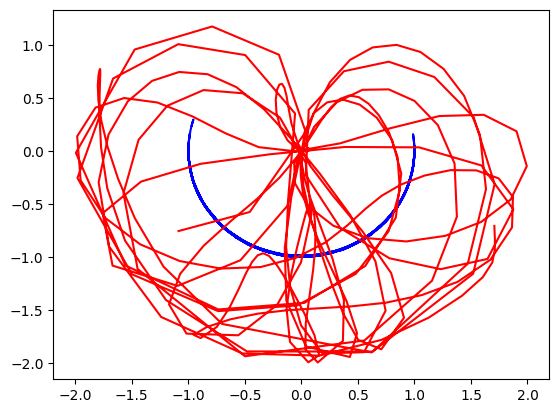

In [10]:
plt.figure()
plt.plot( x1, y1,'b')
plt.plot( x2, y2, 'r')

plt.show()

# Intensity

In [18]:

t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Intensity", split = True,   dt=1/100, nInFrames = 5,sr = 10 ,  noise=False, shapeType='simple')
#print(train_x.shape)
#print(val_x.shape)
#print(len(train_dataloader))
#print(len(test_dataloader))

<Figure size 640x480 with 0 Axes>

### Visuals

In [65]:
genData.generateVideo(a,DynamicsType = "Intensity", name = "Intensity_Original_video")

(10000,)


<function matplotlib.pyplot.show(close=None, block=None)>

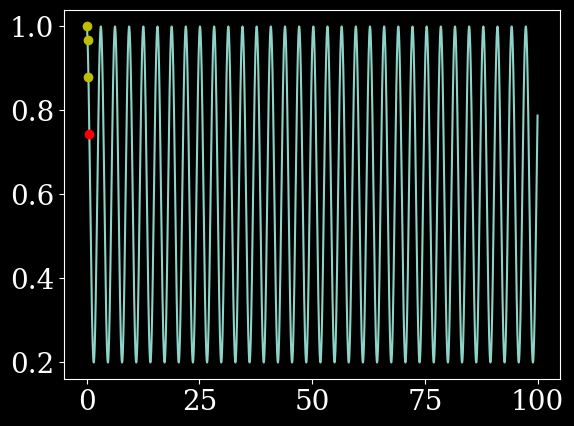

In [106]:
print(a.shape)

plt.figure()
plt.plot(t,a)
sr = 20
for i in range(4):
    if i == 3:
        plt.plot(t[i*sr],a[i*sr],'ro')
    else:
        plt.plot(t[i*sr],a[i*sr],'yo')

plt.show

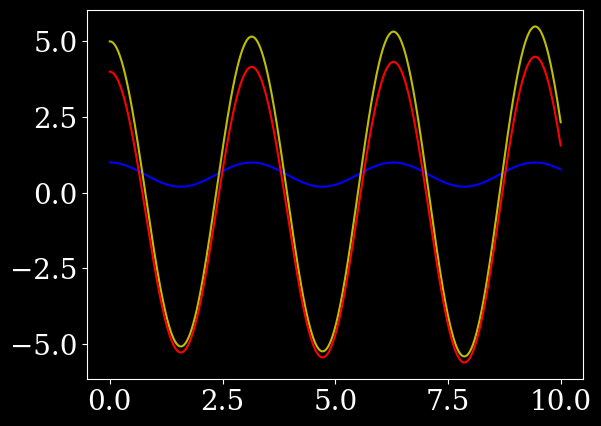

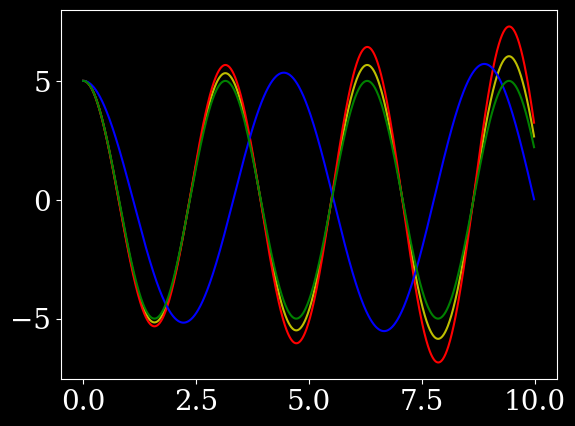

In [49]:
yd = np.zeros(2000)
yd[0]= a[0]*5
yd[1] = a[1]*5
yd[2] = a[2]*5

dt = 1/200

for i in range(2000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

plt.figure()
plt.plot(t,a,'b')
plt.plot(t,yd,'y')
plt.plot(t,yd-a,'r')
plt.show()

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

    td[i+3] = td[i+2] + dt

plt.figure()

plt.plot(td,yd,'y')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'r')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y1-y0) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'b')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()
    

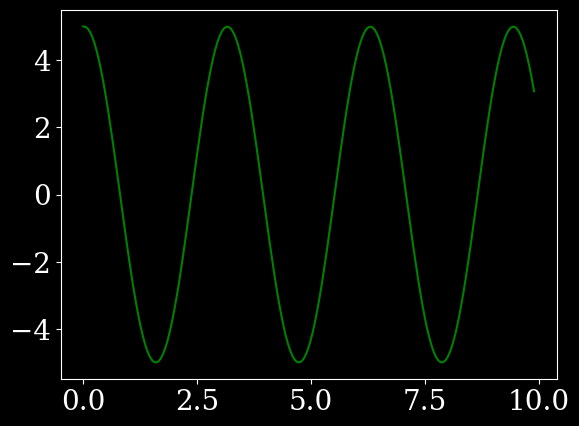

In [50]:
yd = np.zeros(200)
td = np.zeros(200)

td[0]= t[0]
td[1] = t[10]
td[2] = t[10]

yd[0]= a[0]*5
yd[1] = a[10]*5
yd[2] = a[10]*5

dt = 10/200

for i in range(200-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()

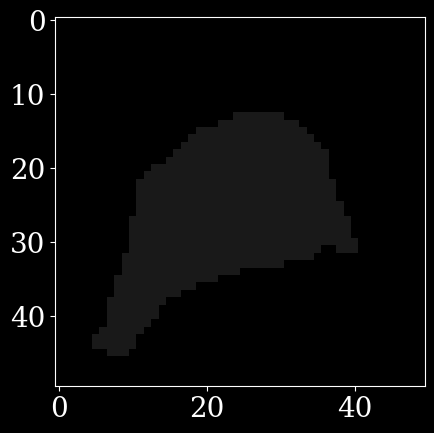

In [51]:
aa = genData.create_intensity_image(0.1, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)


Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


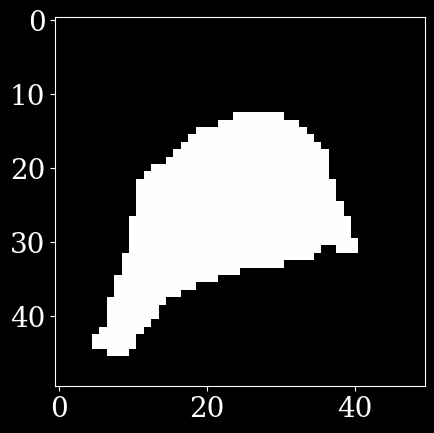

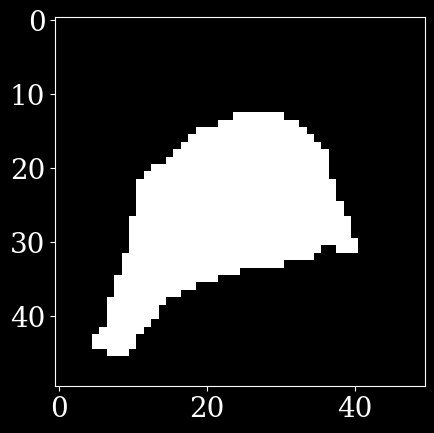

In [9]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][30,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

torch.Size([5, 366, 262])


TypeError: Invalid shape (366, 262, 5) for image data

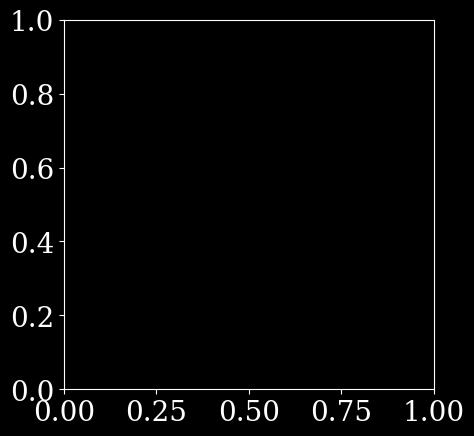

In [20]:
vu.visualize_loader(train_dataloader)

### Model

In [77]:


modelfull= modelineal.AE(dt=0.05, initw=True)
#modelfull= mainmodel.AEModel(dt=0.25, initw=True)#
modelfull, train_losses, val_losses, accuracy_list  = train.train(modelfull, train_dataloader, test_dataloader, 'fullmodel', type='encoder-decoder')



Using device: cpu


epoch: 10 	 training loss: 0.02393619288865011 	 validation loss: 0.27576659790550667
epoch: 20 	 training loss: 0.023681869482970797 	 validation loss: 0.11160225436712305
epoch: 30 	 training loss: 0.023644985924474896 	 validation loss: 0.07640182816733916
epoch: 40 	 training loss: 0.02363846118620131 	 validation loss: 0.06261550278092425
epoch: 50 	 training loss: 0.02367048117215745 	 validation loss: 0.057478685242434345
epoch: 60 	 training loss: 0.023703070355113594 	 validation loss: 0.05563825694844127
epoch: 70 	 training loss: 0.02370201895420905 	 validation loss: 0.05281480976069967
epoch: 80 	 training loss: 0.02352042862563394 	 validation loss: 0.047235113413383566
epoch: 90 	 training loss: 0.023520257283817046 	 validation loss: 0.04210684293260177
epoch: 100 	 training loss: 0.023377364840125665 	 validation loss: 0.0411520516499877


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


alpha,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
alpha,4.0
beta,0.0
train_loss,0.02338
validation_loss,0.04115


<Figure size 640x480 with 0 Axes>

In [55]:
for name, param in modelfull.named_parameters():
    print(name, param.shape, param.requires_grad)

print(modelfull.pModel.alpha[0])
print(modelfull.pModel.beta[0]) 

encoder.linear.0.weight torch.Size([1000, 2500]) True
encoder.linear.0.bias torch.Size([1000]) True
encoder.linear.1.weight torch.Size([500, 1000]) True
encoder.linear.1.bias torch.Size([500]) True
encoder.linear.2.weight torch.Size([1, 500]) True
encoder.linear.2.bias torch.Size([1]) True
decoder.l1.weight torch.Size([10, 1]) True
decoder.l2.weight torch.Size([1000, 10]) True
decoder.l3.weight torch.Size([2500, 1000]) True
pModel.alpha torch.Size([1]) False
pModel.beta torch.Size([1]) False
tensor(4.)
tensor(0.)


In [34]:
def phyModel(y1, y2, dt):
    alpha = 4
    return y2 + (y2-y1) - dt*dt*(alpha*y1)

print(phyModel( 0.9980, 0.9920, 0.05))

0.97602


In [74]:
visual_loader= loader.getLoaderIn(a,  split = False, type = "Dataset3d",  dt=0.05,nInFrames = 3,sr = 10 ,   noise=False, shapeType='simple')
vu.visualize(modelfull, visual_loader, video_name = 'neuronFullModel_ExpVsPred.mp4')
vu.CompareLatent(modelfull, visual_loader)

### Test Decoder

In [8]:
t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Intensity")
GANDecoder = decoders.convGAN()
GANDecoder, train_losses, val_losses, accuracy_list  = train.trainGAN(GANDecoder, train_dataloader, test_dataloader, '../Results/Intensity_GAN')

Using device: cuda


epoch: 5 	 training loss: 0.2310685070698999
epoch: 10 	 training loss: 0.42702712882082206
epoch: 15 	 training loss: 0.349165072040209
epoch: 20 	 training loss: 0.34118525128139154
epoch: 25 	 training loss: 0.044570964731525595
epoch: 30 	 training loss: 0.37363889617226703
epoch: 35 	 training loss: 0.01542553780145236
epoch: 40 	 training loss: 0.23954369564805292
epoch: 45 	 training loss: 0.033283488811399906
epoch: 50 	 training loss: 0.01682553405696712


train_loss,▆▄▅▄▄▅▄▅██▇█▆▇▇█▅▂▁▁▂▆▇▇▅▁▂▅▁▁▁▄▂▂▂▂▂▁▁▁
train_loss,0.01683


<Figure size 640x480 with 0 Axes>

In [9]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Intensity")
vu.visualize_dec(GANDecoder.generator, visual_loader, video_name = './Results/Intensity_Decoder_ExpVsPred.mp4')

Video saved as ./Results/Intensity_Decoder_ExpVsPred.mp4


### Test decoder difussion model

08:34:31 - INFO: Starting epoch 0:
100%|██████████| 572/572 [04:16<00:00,  2.23it/s, MSE=0.00466]
08:38:47 - INFO: Sampling 14 new images....
999it [02:04,  8.02it/s]
08:40:52 - INFO: Sampling 14 new images....
999it [02:18,  7.20it/s]


<Figure size 640x480 with 0 Axes>

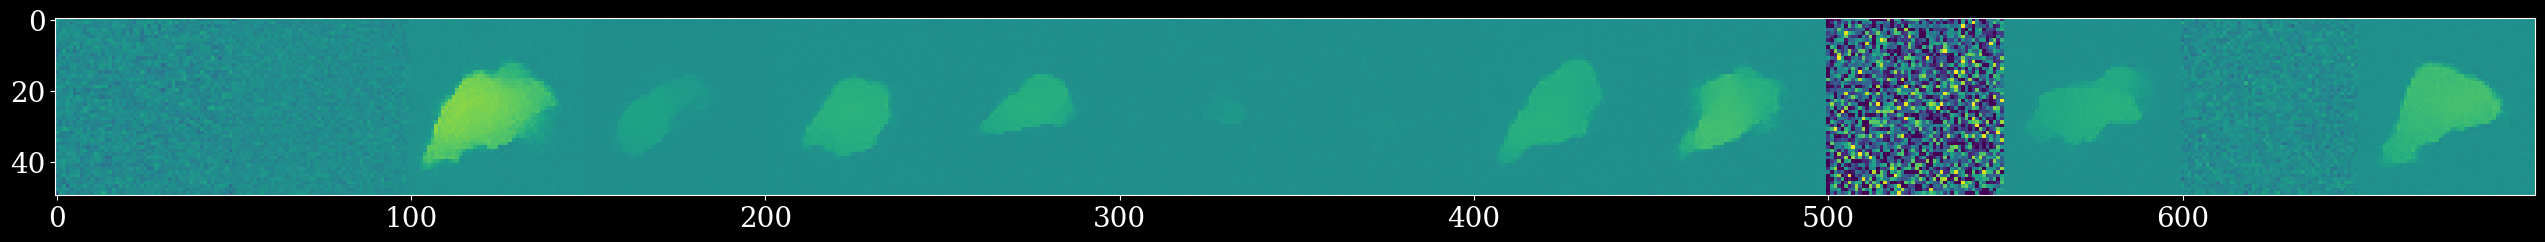

08:43:11 - INFO: Starting epoch 1:
100%|██████████| 572/572 [08:04<00:00,  1.18it/s, MSE=0.00918]
08:51:16 - INFO: Starting epoch 2:
100%|██████████| 572/572 [07:26<00:00,  1.28it/s, MSE=0.00481]
08:58:42 - INFO: Starting epoch 3:
100%|██████████| 572/572 [06:31<00:00,  1.46it/s, MSE=0.00725]
09:05:14 - INFO: Starting epoch 4:
100%|██████████| 572/572 [07:27<00:00,  1.28it/s, MSE=0.00574]
09:12:41 - INFO: Starting epoch 5:
 81%|████████  | 463/572 [06:22<01:30,  1.21it/s, MSE=0.00417]


KeyboardInterrupt: 

In [2]:
from src.models.cdfm import cdfm as cdfm
t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Intensity")
diffmodel = cdfm.launch(train_dataloader)

### Test encoder n phys

In [20]:
t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Intensity", split = True,   dt=1/100, nInFrames = 5,sr = 20 ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/Intensity_Decoder', loss_name='latent_loss')

Using device: cuda


Initial Loss 	 training loss: 14.361926515092733 	 validation loss: 42.682813771565755
epoch: 5 	 training loss: 0.5610069981832736 	 validation loss: 28.991632747650147
epoch: 10 	 training loss: 0.5291942683188057 	 validation loss: 27.32930113474528
epoch: 15 	 training loss: 0.49505788673032153 	 validation loss: 27.25518379211426
epoch: 20 	 training loss: 0.4193941386160158 	 validation loss: 26.969442812601724
epoch: 25 	 training loss: 0.49340475641703796 	 validation loss: 26.933689022064208
epoch: 30 	 training loss: 0.4515281007304667 	 validation loss: 27.316829522450764
epoch: 35 	 training loss: 0.4864329782800998 	 validation loss: 26.79075927734375
epoch: 40 	 training loss: 0.4923679676050177 	 validation loss: 27.717871157328286
epoch: 45 	 training loss: 0.36806320510653834 	 validation loss: 26.878485870361327
epoch: 50 	 training loss: 0.44436603036486666 	 validation loss: 26.948036607106527


alpha,█▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
beta,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
alpha,3.62025
beta,0.19641
train_loss,0.44437
validation_loss,26.94804


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
visual_loader= loader.getLoader(a,type="Intensity", split = False,   dt=1/100, nInFrames = 3,sr = 10 ,  noise=False, shapeType='simple')
vu.CompareLatent_end_phys(latentEncoder, visual_loader)

<Figure size 640x480 with 0 Axes>

# Scale

In [ ]:
t,a = genData.generateDynamics(max=2, min = 0)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Scale", split = True,  dt=1/100, nInFrames = 3,sr = 20 ,  noise=False, shapeType='simple')

<Figure size 640x480 with 0 Axes>

### visuals

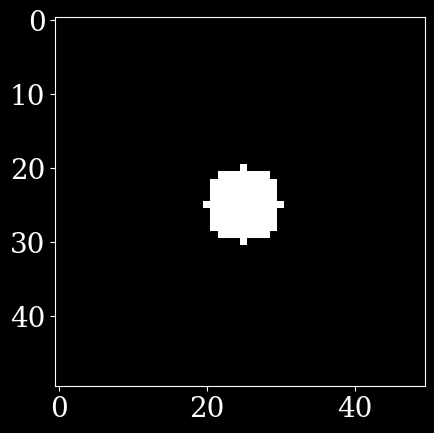

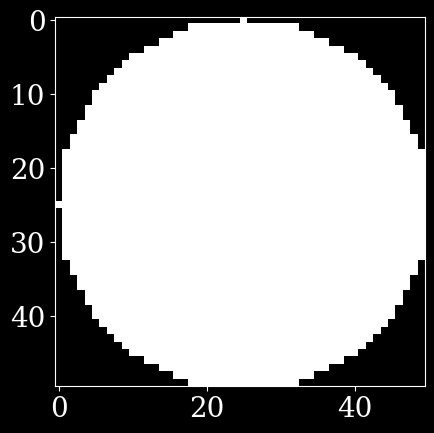

In [ ]:
aa = genData.create_scale_image(0, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)

aa = genData.create_scale_image(2, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)

In [ ]:
vu.visualize_loader(train_dataloader)

In [ ]:
genData.generateVideo(a,DynamicsType = "Scale", name = "Scale_Original_video")

### Test Decoder

In [ ]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Scale")
linearDecoder = decoders.mlp(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/Scale_Decoder', loss_name='decoder_loss')

Using device: cuda


epoch: 10 	 training loss: 0.05719152551144362 	 validation loss: 0.03342188042230331
epoch: 20 	 training loss: 0.056892652474343774 	 validation loss: 0.03397236556674425
epoch: 30 	 training loss: 0.056780308820307254 	 validation loss: 0.03567916749475094
epoch: 40 	 training loss: 0.05668225105851889 	 validation loss: 0.03647880177371777
epoch: 50 	 training loss: 0.05665849100798368 	 validation loss: 0.03686625983279485
epoch: 60 	 training loss: 0.056596668548882005 	 validation loss: 0.03693357468224489
epoch: 70 	 training loss: 0.05653765968978405 	 validation loss: 0.03708248571134531
epoch: 80 	 training loss: 0.05646611392498016 	 validation loss: 0.03717367028674254
epoch: 90 	 training loss: 0.05635320872068405 	 validation loss: 0.03733219607518269
epoch: 100 	 training loss: 0.056242847628891465 	 validation loss: 0.037558308229423486


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,0.05624
validation_loss,0.03756


<Figure size 640x480 with 0 Axes>

In [ ]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Scale")
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/Scale_Decoder_ExpVsPred.mp4')

Video saved as ./Results/Scale_Decoder_ExpVsPred.mp4


### Test Encoder Phys

In [ ]:
t,a = genData.generateDynamics(max=2, min = 0)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Scale", split = True,  dt=1/100, nInFrames = 5,sr = 20 ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/Scale_Decoder', loss_name='latent_loss')

Using device: cuda


epoch: 5 	 training loss: 0.0831983064203278 	 validation loss: 5.880365331967671
epoch: 10 	 training loss: 0.09457324856801735 	 validation loss: 5.976184503237406
epoch: 15 	 training loss: 0.08866627315843575 	 validation loss: 6.130231698354085
epoch: 20 	 training loss: 0.08236766554912937 	 validation loss: 5.817626293500265
epoch: 25 	 training loss: 0.08172455830933141 	 validation loss: 6.006799844900767
epoch: 30 	 training loss: 0.08531901880774481 	 validation loss: 5.981741388638814
epoch: 35 	 training loss: 0.09753780782426356 	 validation loss: 6.270526166756948
epoch: 40 	 training loss: 0.09021688880481821 	 validation loss: 5.9914109667142235
epoch: 45 	 training loss: 0.07726214678584775 	 validation loss: 5.997089966138204
epoch: 50 	 training loss: 0.09415612198970458 	 validation loss: 5.94846301873525


alpha,▁▄▆▇████████████████████████████████████
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
alpha,4.07017
beta,1.0
train_loss,0.09416
validation_loss,5.94846


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
visual_loader= loader.getLoader(a,type="Scale", split = False,   dt=1/100, nInFrames = 5,sr = 20 ,  noise=False, shapeType='simple')
vu.CompareLatent_end_phys(latentEncoder, visual_loader)

<Figure size 640x480 with 0 Axes>

# Dataset baseline

### MNIST moving

In [24]:
torch.cuda.empty_cache() 
torch.manual_seed(42)

data_folder = np.load('Data/color_mnist.npz')
data_train = data_folder['train_x']
dt = 0.3
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)
latentEncoder = mainmodel.EndPhys(dt = dt, in_size=64, n_mask = 2, in_channels = 3, latent_dim=4, initw=True)
#latentEncoder = mainmodel.EndPhysMultiple(dt = dt, in_size=64, n_mask = 2, in_channels = 3, latent_dim=2, initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/Motion_Decoder', loss_name='latent_loss')

In [ ]:
visual_loader  = loader.getLoader_folder(data_train, split=False)
vu.view_masks(latentEncoder, visual_loader, iters = 2)

In [40]:
print(data_train.shape)
print(data_train[0].shape)
print(data_train[0].transpose( (0,3,1,2) ).shape)


(5000, 12, 64, 64, 3)
(12, 64, 64, 3)
(12, 3, 64, 64)


max: 254


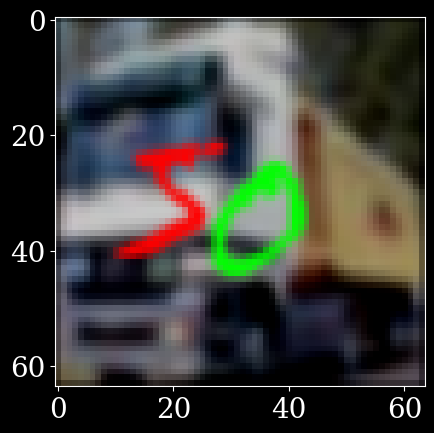

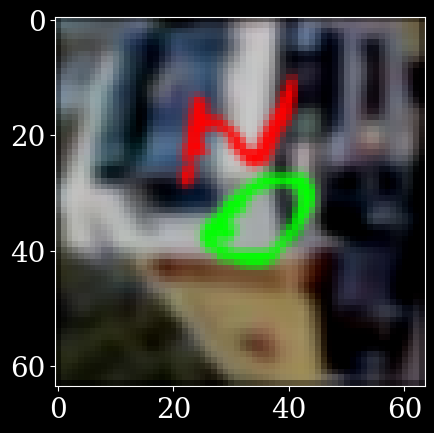

In [31]:
data_train[0,0,:,:,:].shape

print("max:", np.max(data_train[0,0,:,:,:]))

plt.figure()
plt.imshow(data_train[0,0,:,:,:])
plt.show()

data_train2 = data_train[0].transpose( (0,3,1,2))

test_img = data_train2[0,:,:,:]

plt.figure()

plt.imshow(test_img.transpose(2, 1, 0))
plt.show()


### 3 body gravity

In [16]:
torch.cuda.empty_cache() 
torch.manual_seed(0)

data_folder = np.load('Data/color_3bp.npz')
data_train = data_folder['train_x']
dt = 0.5
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)
latentEncoder = mainmodel.EndPhys(dt = dt, in_size=36, n_mask = 2, in_channels = 3, latent_dim=6, pmodel = "gravity_ode", initw=True)
#latentEncoder = mainmodel.EndPhysMultiple(dt = dt, in_size=64, n_mask = 2, in_channels = 3, latent_dim=2, initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/3bpn_Decoder', loss_name='latent_loss')

Using device: cpu


Nan values in gravity_ode
Nan values in gravity_ode
loss tensor(nan)


UnboundLocalError: cannot access local variable 'epoch' where it is not associated with a value

In [10]:
a = torch.randn(3, 2)
print(a)
print(a+1e1)




tensor([[ 0.5615, -1.0040],
        [-2.1960,  0.7584],
        [ 0.8105,  1.5970]])
tensor([[10.5615,  8.9960],
        [ 7.8040, 10.7584],
        [10.8105, 11.5970]])


In [96]:
x1 = a[1,0,0]
y1 = a[1,0,1]
x2 = a[1,2,0]
y2 = a[1,2,1]

manual_distance = torch.sqrt((x2-x1)**2 + (y2-y1)**2)
print(manual_distance)
manual_distance = manual_distance +1e-5
print(manual_distance)
manual_distance = manual_distance.pow(3)
print(manual_distance)
manual_distance = 1/manual_distance

print(manual_distance)


tensor(0.5709)
tensor(0.5709)
tensor(0.1861)
tensor(5.3735)


In [71]:
print(torch.div( direction[:,:,:].transpose(1,2), distance[:,:]) .transpose(1,2))

print(torch.matmul( direction[:,:,:].transpose(1,2), 1/(distance[:,:].unsqueeze(2)) ) .transpose(1,2))

print(direction[0,0,:]/distance[0,0])
print(direction[0,1,:].T/distance[0,1])
print(direction[0,2,:].T/distance[0,2])

print(direction[1,0,:].T/distance[1,0])
print(direction[1,1,:].T/distance[1,1])
print(direction[1,2,:].T/distance[1,2])

tensor([[[ 0.0674,  1.0867],
         [-0.5231, -0.4149],
         [ 0.4128, -1.0972]],

        [[ 0.3425, -0.9278],
         [-1.4141,  0.7252],
         [ 0.8301,  0.0015]]])
tensor([[[-0.0429, -0.7654]],

        [[ 0.6846, -0.2011]]])
tensor([0.0674, 0.9977])
tensor([-0.5231, -0.8522])
tensor([ 0.4128, -0.9108])
tensor([ 0.3731, -0.9278])
tensor([-0.6885,  0.7252])
tensor([1.0000, 0.0015])


In [34]:
data_folder = np.load('Data/color_3bp.npz')
data_train = data_folder['train_x']

print(data_train.shape)

(5000, 20, 36, 36, 3)


# Test

In [9]:
points = torch.rand(2, 6)  # Generate random points

# Reshape the tensor to have 3 dimensions: (32, 3, 2)
points_3d = points.view(-1, 3, 2)

# Calculate the Euclidean distance between each pair of points
distances = torch.norm(points_3d, dim=2)


distances_torch = torch.cdist(points_3d, points_3d)

distance_manual = torch.sqrt(torch.sum((points_3d[:, None] - points_3d[None, :])**2, dim=-1))




In [32]:
#points = torch.rand(1, 3,2)

permute = torch.roll(points, -1,1)



print(points)
print(permute)


print(points - permute)

cdist = torch.cdist(points, permute)

print(cdist)

x0 = points[0,1,0]
y0 = points[0,1,1]
x1 = points[0,2,0]
y1 = points[0,2,1]

distance = torch.sqrt((x1-x0)**2 + (y1-y0)**2)

print(distance)



tensor([[[0.7672, 0.6757],
         [0.6625, 0.2297],
         [0.9545, 0.6099]]])
tensor([[[0.6625, 0.2297],
         [0.9545, 0.6099],
         [0.7672, 0.6757]]])
tensor([[[ 0.1047,  0.4460],
         [-0.2920, -0.3802],
         [ 0.1873, -0.0658]]])
tensor([[[0.4582, 0.1985, 0.0000],
         [0.0000, 0.4794, 0.4582],
         [0.4794, 0.0000, 0.1985]]])
tensor(0.4794)


In [26]:
points = torch.rand(1, 6)

print(points.view(-1, 3, 2))
print(points.view(points.shape[0], -1, 2))


tensor([[[0.0766, 0.8460],
         [0.3624, 0.3083],
         [0.0850, 0.0029]]])
tensor([[[0.0766, 0.8460],
         [0.3624, 0.3083],
         [0.0850, 0.0029]]])


In [10]:
print(distances_torch)
print(points_3d)

print(distance_manual)

tensor([[[0.0000, 0.5122, 0.9567],
         [0.5122, 0.0000, 0.5930],
         [0.9567, 0.5930, 0.0000]],

        [[0.0000, 0.5621, 0.5425],
         [0.5621, 0.0000, 0.0827],
         [0.5425, 0.0827, 0.0000]]])
tensor([[[0.9516, 0.0753],
         [0.8860, 0.5832],
         [0.3376, 0.8090]],

        [[0.5779, 0.9040],
         [0.5547, 0.3423],
         [0.6343, 0.3644]]])
tensor([[[0.0000, 0.0000, 0.0000],
         [0.9090, 0.4097, 0.5345]],

        [[0.9090, 0.4097, 0.5345],
         [0.0000, 0.0000, 0.0000]]])


In [14]:
x0 = points_3d[0,2,0]
y0 = points_3d[0,2,1]
x1 = points_3d[0,1,0]
y1 = points_3d[0,1,1]

distance = torch.sqrt((x1-x0)**2 + (y1-y0)**2)
print(distance)

aa = points_3d[0,:,:]
print(aa.shape)

distances_torch = torch.cdist(aa, aa)
print(distances_torch)

tensor(0.5930)
torch.Size([3, 2])
tensor([[0.0000, 0.5122, 0.9567],
        [0.5122, 0.0000, 0.5930],
        [0.9567, 0.5930, 0.0000]])


In [3]:
Data = np.load('Data/color_mnist.npz')

In [7]:
print(Data['train_x'].shape)

(5000, 12, 64, 64, 3)


In [14]:
x = torch.rand(2,4)
print(x)

# reshape x to 3d tensor size 2x2
x = x.view(-1, 2, 2)
print(x)
print(x.shape)

tensor([[0.1194, 0.5001, 0.1685, 0.3910],
        [0.6614, 0.2581, 0.2352, 0.7478]])
tensor([[[0.1194, 0.5001],
         [0.1685, 0.3910]],

        [[0.6614, 0.2581],
         [0.2352, 0.7478]]])
torch.Size([2, 2, 2])


In [18]:
x = torch.rand(2,4)
print(x)

# reshape x to 3d tensor size 2x2

x = x.reshape(-1, 2, 2)
print(x)
print(x.shape)

tensor([[0.0610, 0.2224, 0.3052, 0.3651],
        [0.2652, 0.7166, 0.0498, 0.3509]])
tensor([[[0.0610, 0.2224],
         [0.3052, 0.3651]],

        [[0.2652, 0.7166],
         [0.0498, 0.3509]]])
torch.Size([2, 2, 2])


In [12]:
x = torch.rand(32,50,50)
x = x.view(x.shape[0], -1)
print(x.shape)

x = torch.rand(32,3,50,50)
x = x.view(x.shape[0], -1)
print(x.shape)

torch.Size([32, 2500])
torch.Size([32, 7500])


### Difussion things

t tensor([11, 13,  6, 34, 81, 67, 64, 97, 74, 82])
t_unsqueeze tensor([[11.],
        [13.],
        [ 6.],
        [34.],
        [81.],
        [67.],
        [64.],
        [97.],
        [74.],
        [82.]])
inv_freq tensor([1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04])
tensor([[-1.0000,  0.9851,  0.2728,  0.0438,  0.0069],
        [ 0.4202,  0.8825,  0.3208,  0.0517,  0.0082],
        [-0.2794,  0.8140,  0.1501,  0.0239,  0.0038],
        [ 0.5291, -0.7799,  0.7539,  0.1349,  0.0215],
        [-0.6299,  0.2679,  0.8943,  0.3169,  0.0511],
        [-0.8555, -0.9299,  0.9937,  0.2636,  0.0423],
        [ 0.9200, -0.6583,  0.9993,  0.2520,  0.0404],
        [ 0.3796,  0.3283,  0.6481,  0.3766,  0.0612],
        [-0.9851, -0.7434,  0.9588,  0.2904,  0.0467],
        [ 0.3132,  0.4166,  0.8828,  0.3207,  0.0517]])
pos_enc torch.Size([10, 10])


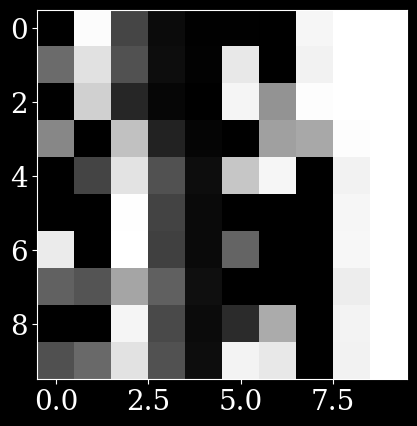

t_pos_encoding tensor([[-1.0000,  0.9851,  0.2728,  0.0438,  0.0069,  0.0044, -0.1717,  0.9621,
          0.9990,  1.0000],
        [ 0.4202,  0.8825,  0.3208,  0.0517,  0.0082,  0.9074, -0.4702,  0.9472,
          0.9987,  1.0000],
        [-0.2794,  0.8140,  0.1501,  0.0239,  0.0038,  0.9602,  0.5809,  0.9887,
          0.9997,  1.0000],
        [ 0.5291, -0.7799,  0.7539,  0.1349,  0.0215, -0.8486,  0.6259,  0.6569,
          0.9909,  0.9998],
        [-0.6299,  0.2679,  0.8943,  0.3169,  0.0511,  0.7767,  0.9634, -0.4474,
          0.9485,  0.9987],
        [-0.8555, -0.9299,  0.9937,  0.2636,  0.0423, -0.5178, -0.3679, -0.1119,
          0.9646,  0.9991],
        [ 0.9200, -0.6583,  0.9993,  0.2520,  0.0404,  0.3919, -0.7528, -0.0368,
          0.9677,  0.9992],
        [ 0.3796,  0.3283,  0.6481,  0.3766,  0.0612, -0.9251, -0.9446, -0.7616,
          0.9264,  0.9981],
        [-0.9851, -0.7434,  0.9588,  0.2904,  0.0467,  0.1717,  0.6688, -0.2840,
          0.9569,  0.9989],
    

In [ ]:
def pos_encoding( t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float() / channels)
        )
        print("inv_freq", inv_freq)
        print(torch.sin(t.repeat(1, channels // 2)* inv_freq))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        print("pos_enc", pos_enc.shape)

        plt.figure()
        plt.imshow(pos_enc, cmap='gray', vmax=1, vmin=0)
        plt.show()

        return pos_enc
t = torch.randint(low=1, high=100, size=(10,))
print("t", t)
t = t.unsqueeze(-1).type(torch.float)
print("t_unsqueeze", t)
t = pos_encoding(t, 10)
print("t_pos_encoding", t)

le tensor(1.2582, grad_fn=<MaxBackward1>)
le tensor(-0.8530, grad_fn=<MinBackward1>)
t torch.Size([10, 10])
t_label_emb torch.Size([10, 10])


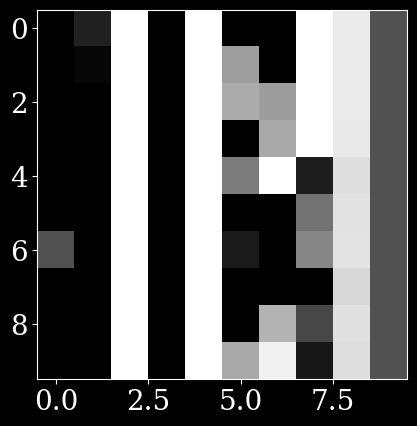

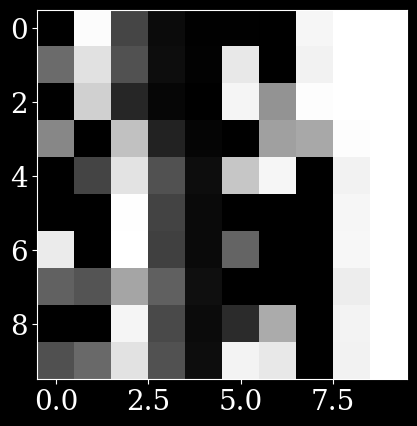

In [ ]:
label_emb = nn.Embedding(1, 10)

y = torch.tensor([0])

le = label_emb(y)
print("le", le.max())
print("le", le.min())
t2 = t+ le
print("t", t.shape)
print("t_label_emb", t2.shape)
#print("t", t)
#print("t_label_emb", t2)

plt.figure()
plt.imshow(t2.detach().numpy(), cmap='gray', vmax=1, vmin=0)
plt.show()
plt.figure()
plt.imshow(t.detach().numpy(), cmap='gray', vmax=1, vmin=0)
plt.show()

### images

In [ ]:
# Assuming batch size is 32 and images are grayscale with dimensions (height, width)
batch_size = 32
height, width = 28, 28  # Example dimensions, adjust as per your images

# Generate a random batch of images (example)
batch_images = torch.rand(batch_size, height, width)

# Reshape the batch to (batch_size, num_pixels)
batch_images_flat = batch_images.view(batch_size, -1)

print(batch_images_flat.shape)
print(batch_images.shape)

# Calculate the variance across the batch for each pixel
variances = torch.var(batch_images_flat, dim=0)

print(variances.shape)

torch.Size([32, 784])
torch.Size([32, 28, 28])
torch.Size([784])


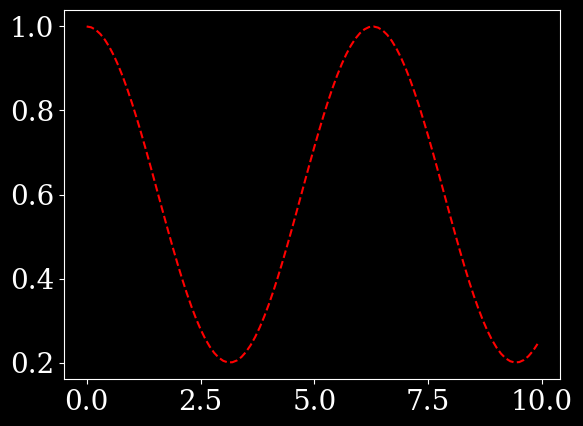

In [ ]:
t = np.arange(0,10, 0.1)
m = (1-0.2)/(1-(-1))
b= 1 - m
x = m*np.cos(t)+b

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = 0.1
for i in range(2, len(t)):
    y2 = y1+ (y1-y0) -dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'--r')
#plt.plot(t,y,'--b')
plt.show()


In [ ]:

t = np.arange(0,2*np.pi, np.pi/100)
x = np.cos(t)

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = np.pi/100
for i in range(2, len(t)):
    y2 = y1+ (y1-y0)*dt +dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'r')
plt.plot(t,y,'b')
plt.show()

## Plots

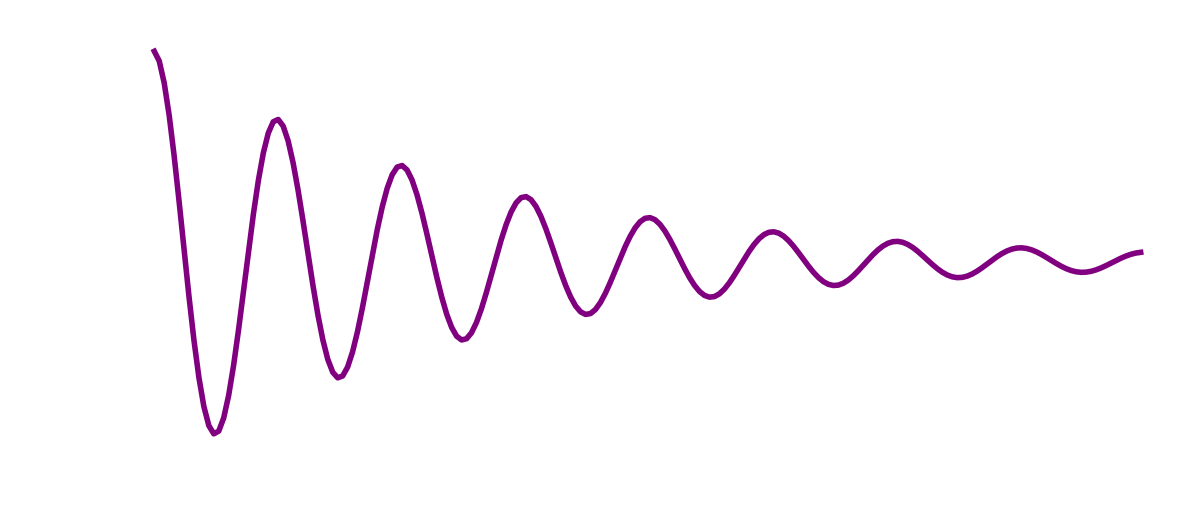

In [ ]:
t = np.arange(0,2*np.pi, np.pi/100)
x = np.exp(-0.5*t)*np.cos(8*t) 

plt.figure(figsize=(14, 6))

plt.plot(t, x, linewidth=4, color='purple')


plt.ylim(-1, 1.2)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.rcParams.update({
    'text.color': 'white',     # Font color
    'axes.labelcolor': 'white',# Axis label color
    'xtick.color': 'white',    # X-axis tick color
    'ytick.color': 'white',    # Y-axis tick color
    'axes.edgecolor': 'white'  # Axis edge color
})
plt.grid(False)

# Save the plot with high resolution and no background
plt.savefig('damped_pendulum_plot.png', dpi=300, transparent=True)
plt.show()

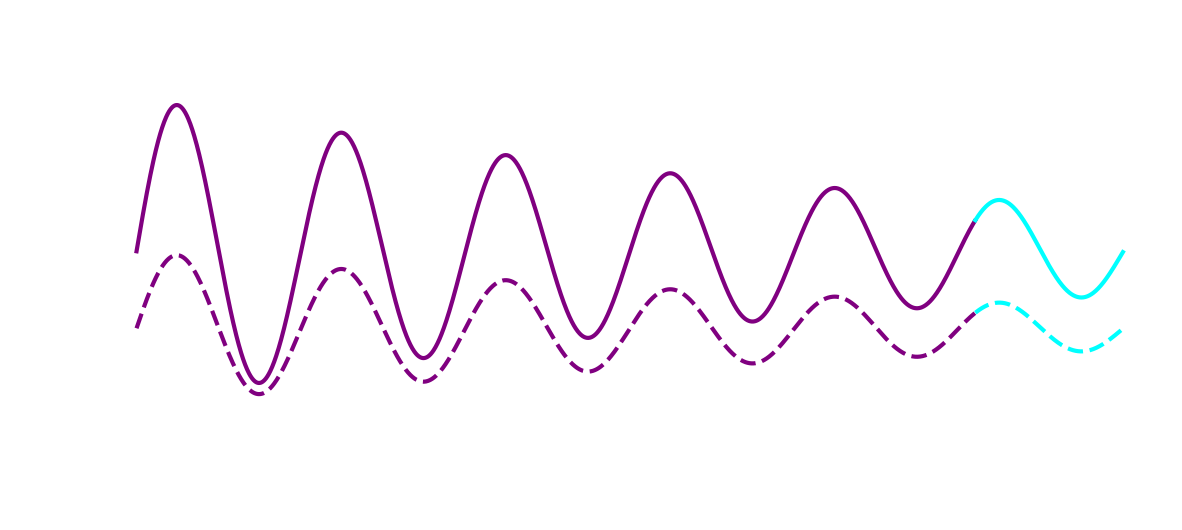

In [ ]:
t = np.arange(0,2*np.pi, np.pi/1000)
x = np.exp(-0.2*t)*np.sin(6*t)
x2 = 0.5*x-0.5


plt.figure(figsize=(14, 6))

testat = 300

plt.plot(t[0:-testat], x[0:-testat], linewidth=3, color='purple')
plt.plot(t[0:-testat], x2[0:-testat], linewidth=3, color='purple', linestyle='--')

plt.plot(t[-testat::], x[-testat::], linewidth=3, color='cyan')
plt.plot(t[-testat::], x2[-testat::], linewidth=3, color='cyan', linestyle='--')


plt.ylim(-1.5, 1.5)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.rcParams.update({
    'text.color': 'white',     # Font color
    'axes.labelcolor': 'white',# Axis label color
    'xtick.color': 'white',    # X-axis tick color
    'ytick.color': 'white',    # Y-axis tick color
    'axes.edgecolor': 'white'  # Axis edge color
})
plt.grid(False)

# Save the plot with high resolution and no background
plt.savefig('damped_pendulum_plot.png', dpi=300, transparent=True)
plt.show()